# Statistics computation

## Notebook setup

In [33]:
# %matplotlib notebook  # does not work in JupyterLab
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import sys

sys.path.append("../..")

In [35]:
import numpy as np
from matplotlib import pyplot as plt

In [36]:
import s1etad

## Product introspection and navigation

In [37]:
filename = (
    "data/"
    "S1A_IW_ETA__AXDV_20230806T211729_20230806T211757_049760_05FBCB_9DD6.SAFE"
)

In [38]:
product = s1etad.Sentinel1Etad(filename)

In [39]:
product

Sentinel1Etad("data/S1A_IW_ETA__AXDV_20230806T211729_20230806T211757_049760_05FBCB_9DD6.SAFE")  # 0x7e31b4418b90
Number of Sentinel-1 slices: 1
Sentinel-1 products list:
  S1A_IW_SLC__1SDV_20230806T211729_20230806T211757_049760_05FBCB_BC56.SAFE
Number of swaths: 3
Swath list: IW1, IW2, IW3
Azimuth time:
  min: 2023-08-06 21:17:29.208211
  max: 2023-08-06 21:17:57.184751
Range time:
  min: 0.0053335639608434815
  max: 0.006389868212274445
Grid sampling:
  x: 8.131672451354599e-07
  y: 0.02932551319648094
  unit: s
Grid spacing:
  x: 200.0
  y: 200.0
  unit: m
Processing settings:
  troposphericDelayCorrection: True
  troposphericDelayCorrectionGradient: True
  ionosphericDelayCorrection: True
  solidEarthTideCorrection: True
  oceanTidalLoadingCorrection: True
  bistaticAzimuthCorrection: True
  dopplerShiftRangeCorrection: True
  FMMismatchAzimuthCorrection: True

In [40]:
swath = product["IW1"]

In [41]:
burst = swath[1]

In [42]:
t, tau = burst.get_burst_grid()
print("t.shape", t.shape)
print("tau.shape", tau.shape)

t.shape (108,)
tau.shape (402,)


In [43]:
correction = burst.get_correction(s1etad.ECorrectionType.SUM, meter=True)

In [44]:
rg_correction = correction["x"]
az_correction = correction["y"]
print("rg_correction.shape", rg_correction.shape)
print("az_correction.shape", az_correction.shape)

rg_correction.shape (108, 402)
az_correction.shape (108, 402)


Text(0.5, 1.0, 'sum correction in range direction')

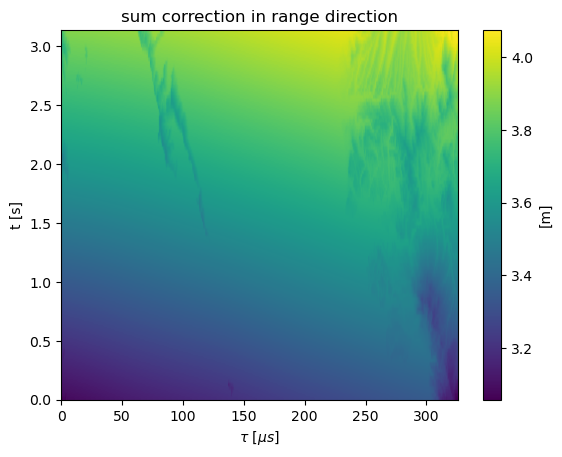

In [45]:
plt.figure()
plt.imshow(
    correction["x"],
    extent=[tau[0] * 1e6, tau[-1] * 1e6, t[0], t[-1]],
    aspect="auto",
)
plt.xlabel(r"$\tau\ [\mu s]$")
plt.ylabel("t [s]")
plt.colorbar().set_label("[{}]".format(correction["unit"]))
plt.title("{} correction in range direction".format(correction["name"]))

## Collect data statistics

**NOTE**: statistics are also available in the XML annotation file included in the S1-ETAD product

In [46]:
import pandas as pd

### Initialize dataframes

In [47]:
x_corrections_names = [
    "tropospheric",
    "ionospheric",
    "geodetic",
    "otl",
    "doppler",
    "sum",
]
xcols = [("", "bIndex"), ("", "t")] + [
    (cname, name)
    for cname in x_corrections_names
    for name in ("min", "mean", "std", "max")
]
xcols = pd.MultiIndex.from_tuples(xcols)
xstats_df = pd.DataFrame(columns=xcols, dtype=np.float64)

y_corrections_names = ["geodetic", "otl", "bistatic", "fmrate", "sum"]
ycols = [("", "bIndex"), ("", "t")] + [
    (cname, name)
    for cname in y_corrections_names
    for name in ("min", "mean", "std", "max")
]
ycols = pd.MultiIndex.from_tuples(ycols)
ystats_df = pd.DataFrame(columns=ycols, dtype=np.float64)

### Collect statistics

In [48]:
xrows = []
yrows = []

for swath in product:
    for burst in swath:
        az, _ = burst.get_burst_grid()
        t = np.mean(az[[0, -1]])

        # range
        row = {("", "bIndex"): burst.burst_index, ("", "t"): t}
        for name in x_corrections_names:
            data = burst.get_correction(name, meter=True)
            row[(name, "min")] = data["x"].min()
            row[(name, "mean")] = data["x"].mean()
            row[(name, "std")] = data["x"].std()
            row[(name, "max")] = data["x"].max()
        xrows.append(row)

        # azimuth
        row = {("", "bIndex"): int(burst.burst_index), ("", "t"): t}
        for name in y_corrections_names:
            # NOTE: meter is False in this case due to a limitation of the
            # current implementation
            data = burst.get_correction(name, meter=True)
            row[(name, "min")] = data["y"].min()
            row[(name, "mean")] = data["y"].mean()
            row[(name, "std")] = data["y"].std()
            row[(name, "max")] = data["y"].max()
        yrows.append(row)

xstats_df = pd.DataFrame(xrows, columns=xcols, dtype=np.float64)
ystats_df = pd.DataFrame(yrows, columns=ycols, dtype=np.float64)

### Inspect results

#### Correction statistics in range direction

In [49]:
xstats_df.head()

tropospheric                               ionospheric  \
  bIndex          t          min      mean       std       max         min   
0    1.0   1.568915     3.008053  3.234029  0.057668  3.361616    0.298202   
1    4.0   4.340176     2.771171  3.224370  0.072341  3.361880    0.298284   
2    7.0   7.096774     2.945506  3.182714  0.056279  3.315454    0.298378   
3   10.0   9.853372     2.641564  3.144260  0.074011  3.286178    0.298469   
4   13.0  12.609971     2.602527  3.092772  0.132585  3.268511    0.298562   

                                 ...       otl             doppler            \
       mean       std       max  ...       std       max       min      mean   
0  0.306018  0.004509  0.314064  ...  0.000585 -0.006255 -0.387818  0.001916   
1  0.306125  0.004521  0.314301  ...  0.000518 -0.006242 -0.401401 -0.003059   
2  0.306257  0.004547  0.314288  ...  0.000399 -0.006260 -0.398034 -0.004197   
3  0.306383  0.004561  0.314512  ...  0.000280 -0.006294 -0.391642 -0.002417   
4  0.306522  0.004626  0.314640  ...  0.000256 -0.006388 -0.390746 -0.000781   

                            sum                                
        std       max       min      mean       std       max  
0  0.220776  0.392171  3.057412  3.586854  0.221667  4.075176  
1  0.225790  0.393946  3.037196  3.572150  0.249083  4.094163  
2  0.223368  0.385729  3.009343  3.529350  0.241088  4.048191  
3  0.222298  0.385544  2.667863  3.492359  0.259266  4.017747  
4  0.223230  0.393230  2.815424  3.441967  0.238379  3.947523  

[5 rows x 26 columns]

#### Maximum value of corrections in range direction

In [50]:
xstats_df.abs().max()

              bIndex    28.000000
              t         26.392962
tropospheric  min        3.378197
              mean       3.687771
              std        0.268407
              max        3.821249
ionospheric   min        0.331433
              mean       0.340329
              std        0.005276
              max        0.349176
geodetic      min        0.066308
              mean       0.063517
              std        0.001449
              max        0.060773
otl           min        0.013393
              mean       0.012385
              std        0.002101
              max        0.009958
doppler       min        0.475958
              mean       0.008562
              std        0.268146
              max        0.468848
sum           min        3.482343
              mean       4.072243
              std        0.400115
              max        4.669038
dtype: float64

#### Correction statistics in azimuth direction

In [51]:
ystats_df.head()

geodetic                                     otl  \
  bIndex          t       min      mean       std       max       min   
0    1.0   1.568915  0.033256  0.033581  0.000147  0.033895 -0.004123   
1    4.0   4.340176  0.033115  0.033442  0.000147  0.033757 -0.004002   
2    7.0   7.096774  0.032976  0.033302  0.000146  0.033618 -0.003974   
3   10.0   9.853372  0.032835  0.033162  0.000146  0.033477 -0.004009   
4   13.0  12.609971  0.032693  0.033020  0.000146  0.033335 -0.004021   

                                 ...  bistatic              fmrate            \
       mean       std       max  ...       std       max       min      mean   
0 -0.003900  0.000074 -0.003679  ...  0.320736 -2.338625 -0.228979  0.047914   
1 -0.003786  0.000092 -0.003583  ...  0.320746 -2.338695 -0.337562  0.069707   
2 -0.003812  0.000070 -0.003649  ...  0.320756 -2.338765 -0.270434  0.072256   
3 -0.003881  0.000049 -0.003746  ...  0.320765 -2.338835 -0.246629  0.087287   
4 -0.003935  0.000032 -0.003879  ...  0.320775 -2.338905 -0.969977  0.029867   

                            sum                                
        std       max       min      mean       std       max  
0  0.068379  0.664657 -3.566790 -2.772001  0.329576 -2.032584  
1  0.089394  0.719700 -3.689494 -2.750318  0.320929 -2.096363  
2  0.124514  0.547098 -3.537063 -2.748021  0.330033 -1.969231  
3  0.175363  1.343980 -3.549836 -2.733285  0.330746 -1.809654  
4  0.217065  0.795282 -4.123705 -2.790985  0.408657 -1.822057  

[5 rows x 22 columns]

#### Maximum value of corrections in azimuth direction

In [52]:
ystats_df.abs().max()

          bIndex    28.000000
          t         26.392962
geodetic  min        0.033960
          mean       0.034267
          std        0.000153
          max        0.034568
otl       min        0.005545
          mean       0.004978
          std        0.000334
          max        0.004679
bistatic  min        3.447857
          mean       2.893556
          std        0.380738
          max        2.339255
fmrate    min        1.127943
          mean       0.131468
          std        0.280620
          max        1.484044
sum       min        4.231225
          mean       2.792112
          std        0.469678
          max        2.108454
dtype: float64

### Plot

<Figure size 640x480 with 0 Axes>

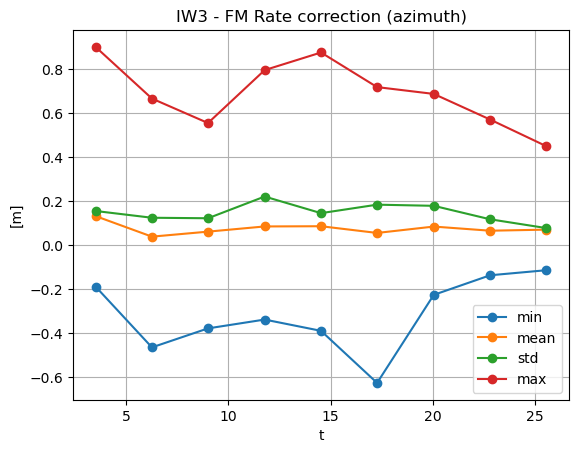

In [53]:
iw3 = product["IW3"]
iw3_df = ystats_df[ystats_df[("", "bIndex")].isin(iw3.burst_list)]

t = iw3_df[("", "t")]
fmrate_df = iw3_df.loc[:, "fmrate"]
fmrate_df.insert(0, "t", t)
fmrate_df = fmrate_df.sort_values(by="t")

plt.figure()
fmrate_df.plot(x="t", style="o-")
plt.ylabel("t [s]")
plt.ylabel("[m]")
plt.title("IW3 - FM Rate correction (azimuth)")
plt.grid()

In [54]:
xstats_df.iloc[xstats_df["sum", "max"].abs().argmax()]

              bIndex    24.000000
              t         22.800587
tropospheric  min        3.378197
              mean       3.676702
              std        0.090626
              max        3.821066
ionospheric   min        0.331312
              mean       0.340210
              std        0.005075
              max        0.349042
geodetic      min       -0.056184
              mean      -0.053722
              std        0.001248
              max       -0.051373
otl           min       -0.012863
              mean      -0.011922
              std        0.001018
              max       -0.009846
doppler       min       -0.473726
              mean      -0.000140
              std        0.268146
              max        0.468038
sum           min        3.435790
              mean       4.062204
              std        0.278705
              max        4.669038
Name: 26, dtype: float64

In [55]:
ystats_df.iloc[ystats_df["sum", "max"].abs().argmax()]

          bIndex    28.000000
          t         26.392962
geodetic  min        0.031968
          mean       0.032294
          std        0.000145
          max        0.032610
otl       min       -0.004078
          mean      -0.003980
          std        0.000048
          max       -0.003893
bistatic  min       -3.447857
          mean      -2.893556
          std        0.320823
          max       -2.339255
fmrate    min       -0.433052
          mean       0.062571
          std        0.082976
          max        0.763479
sum       min       -3.809156
          mean      -2.759478
          std        0.325230
          max       -2.108454
Name: 9, dtype: float64

In [56]:
xstats_df.loc[xstats_df[""]["bIndex"] == 7]["sum"]

,min,mean,std,max
2,3.009343,3.52935,0.241088,4.048191


In [57]:
ystats_df.loc[ystats_df[""]["bIndex"] == 4]["sum"]

,min,mean,std,max
1,-3.689494,-2.750318,0.320929,-2.096363
